## Feature Selection & ML

In [24]:
import os
import numpy as np
import enum
import joblib
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split, ParameterGrid
from sklearn.feature_selection import RFE, SelectKBest, f_classif, VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV


# ==== SETTINGS ====
IS_HYPERPARAM_TUNING = True                                                                                 # !!!!!
featuresDirPath = "/Users/wachiii/Workschii/brain-asd/data/data_children/features/30s_epochbasedNew20250526/"    # !!!!!
modelDirForSavelPath = "/Users/wachiii/Workschii/brain-asd/model/newChildren/20250526_combifeat/"              # !!!!!
OUTLIER_THRESHOLD = 3.0
MODEL_MAIN_DIR_PATH = "/Users/wachiii/Workschii/brain-asd/model"


featuresTypePathDict = {
    "bandpower": "/bandpower/",
    "coherence": "/coherence/",
    "hfd": "/hfd/",
    "relativepower": "/relativepower/",
    "cd": "/cd/", 
    "subbandpower": "/subbandpower/",
    "alphabeta": "/alphabeta/"
}

In [25]:
class BrainMasterMontage(enum.Enum):
    Fp1 = 1
    F3 = 2
    C3 = 3
    P3 = 4
    O1 = 5
    F7 = 6
    T3 = 7
    T5 = 8
    Fz = 9
    Fp2 = 10
    F4 = 11
    C4 = 12
    P4 = 13
    O2 = 14
    F8 = 15
    T4 = 16
    T6 = 17
    Cz = 18
    Pz = 19

## Interquatile Range (IQR) Method

Lower (e.g., 1.0 × IQR) → More values considered outliers (stricter).

Higher (e.g., 3.0 × IQR) → Fewer values considered outliers (looser, only extreme ones removed).

In [26]:
def remove_outliers_iqr_3d(data, threshold=OUTLIER_THRESHOLD):
    numEpochs, numBands, numChannels = data.shape
    mask = np.ones(numEpochs, dtype=bool)
    for band in range(numBands):
        for ch in range(numChannels):
            values = data[:, band, ch]
            Q1 = np.percentile(values, 25)
            Q3 = np.percentile(values, 75)
            IQR = Q3 - Q1
            lowerBound = Q1 - threshold * IQR
            upperBound = Q3 + threshold * IQR
            mask &= (values >= lowerBound) & (values <= upperBound)
    return data[mask], mask


def remove_outliers_iqr_2d(data, threshold=OUTLIER_THRESHOLD):
    numEpochs, numChannels = data.shape
    mask = np.ones(numEpochs, dtype=bool)
    for ch in range(numChannels):
        values = data[:, ch]
        Q1 = np.percentile(values, 25)
        Q3 = np.percentile(values, 75)
        IQR = Q3 - Q1
        lowerBound = Q1 - threshold * IQR
        upperBound = Q3 + threshold * IQR
        mask &= (values >= lowerBound) & (values <= upperBound)
    return data[mask], mask


def remove_outliers(data, threshold=OUTLIER_THRESHOLD):
    if len(data.shape) == 3:  
        return remove_outliers_iqr_3d(data, threshold)
    elif len(data.shape) == 2:  
        return remove_outliers_iqr_2d(data, threshold)
    else:
        raise ValueError("Data must be either 2D or 3D.")

## Prepare Feature 🍳

In [27]:
def get_feature(featureTypes, dataFeaturesDirPath, channelsSelectedSetLst, threshold=3):
    featuresPathDict = {}
    for featureType in featureTypes:
        featuresPathDict[f"hc{featureType.capitalize()}dataFeaturesPath"] = (
            dataFeaturesDirPath + featuresTypePathDict[featureType] + f"{featureType}_HC.npy")
        featuresPathDict[f"asd{featureType.capitalize()}dataFeaturesPath"] = (
            dataFeaturesDirPath + featuresTypePathDict[featureType] + f"{featureType}_ASD.npy")
        featuresPathDict[f"hc{featureType.capitalize()}dataUnseenFeaturesPath"] = (
            dataFeaturesDirPath + featuresTypePathDict[featureType] + f"{featureType}_HC_unseen.npy")
        featuresPathDict[f"asd{featureType.capitalize()}dataUnseenFeaturesPath"] = (
            dataFeaturesDirPath + featuresTypePathDict[featureType] + f"{featureType}_ASD_unseen.npy")

    hcFeaturesDict, asdFeaturesDict = {}, {}
    hcUnseenFeaturesDict, asdUnseenFeaturesDict = {}, {}

    for featureType in featureTypes:
        try:
            hcFeatures = np.load(featuresPathDict[f"hc{featureType.capitalize()}dataFeaturesPath"])
            asdFeatures = np.load(featuresPathDict[f"asd{featureType.capitalize()}dataFeaturesPath"])
            hcUnseenFeatures = np.load(featuresPathDict[f"hc{featureType.capitalize()}dataUnseenFeaturesPath"])
            asdUnseenFeatures = np.load(featuresPathDict[f"asd{featureType.capitalize()}dataUnseenFeaturesPath"])

            # Select channels based on channelsSelectedSetLst
            hcFeatures = hcFeatures[..., channelsSelectedSetLst]
            asdFeatures = asdFeatures[..., channelsSelectedSetLst]
            hcUnseenFeatures = hcUnseenFeatures[..., channelsSelectedSetLst]
            asdUnseenFeatures = asdUnseenFeatures[..., channelsSelectedSetLst]

            # Align dimensions before concatenation (if needed)
            min_dim_hc = hcFeatures.shape[1]
            hcFeatures = hcFeatures[:, :min_dim_hc]

            min_dim_asd = asdFeatures.shape[1]
            asdFeatures = asdFeatures[:, :min_dim_asd]

            min_dim_hc_unseen = hcUnseenFeatures.shape[1]
            hcUnseenFeatures = hcUnseenFeatures[:, :min_dim_hc_unseen]

            min_dim_asd_unseen = asdUnseenFeatures.shape[1]
            asdUnseenFeatures = asdUnseenFeatures[:, :min_dim_asd_unseen]

            hcFeaturesDict[f"hc{featureType.capitalize()}Features"] = hcFeatures
            asdFeaturesDict[f"asd{featureType.capitalize()}Features"] = asdFeatures
            hcUnseenFeaturesDict[f"hc{featureType.capitalize()}UnseenFeatures"] = hcUnseenFeatures
            asdUnseenFeaturesDict[f"asd{featureType.capitalize()}UnseenFeatures"] = asdUnseenFeatures
        except FileNotFoundError as e:
            print(f"File not found: {e}")

    # Remove outliers
    for key in hcFeaturesDict.keys():
        hcFeaturesDict[key], _ = remove_outliers(hcFeaturesDict[key], threshold)
    for key in asdFeaturesDict.keys():
        asdFeaturesDict[key], _ = remove_outliers(asdFeaturesDict[key], threshold)
    # for key in hcUnseenFeaturesDict.keys():
    #     hcUnseenFeaturesDict[key], _ = remove_outliers(hcUnseenFeaturesDict[key], threshold)
    # for key in asdUnseenFeaturesDict.keys():
    #     asdUnseenFeaturesDict[key], _ = remove_outliers(asdUnseenFeaturesDict[key], threshold)

    # Find the minimum number of samples across all HC and ASD features
    min_hc_samples = min([hcFeaturesDict[key].shape[0] for key in hcFeaturesDict.keys()])
    min_asd_samples = min([asdFeaturesDict[key].shape[0] for key in asdFeaturesDict.keys()])
    min_hc_unseen_samples = min([hcUnseenFeaturesDict[key].shape[0] for key in hcUnseenFeaturesDict.keys()])
    min_asd_unseen_samples = min([asdUnseenFeaturesDict[key].shape[0] for key in asdUnseenFeaturesDict.keys()])

    # Truncate features to the minimum number of samples
    for key in hcFeaturesDict.keys():
        hcFeaturesDict[key] = hcFeaturesDict[key][:min_hc_samples]
    for key in asdFeaturesDict.keys():
        asdFeaturesDict[key] = asdFeaturesDict[key][:min_asd_samples]
    for key in hcUnseenFeaturesDict.keys():
        hcUnseenFeaturesDict[key] = hcUnseenFeaturesDict[key][:min_hc_unseen_samples]
    for key in asdUnseenFeaturesDict.keys():
        asdUnseenFeaturesDict[key] = asdUnseenFeaturesDict[key][:min_asd_unseen_samples]

    # === Balance unseen features to have equal number of samples ===
    if len(hcUnseenFeaturesDict) > 0 and len(asdUnseenFeaturesDict) > 0:
        hc_keys = list(hcUnseenFeaturesDict.keys())
        asd_keys = list(asdUnseenFeaturesDict.keys())
        min_unseen = min(
            min([hcUnseenFeaturesDict[k].shape[0] for k in hc_keys]),
            min([asdUnseenFeaturesDict[k].shape[0] for k in asd_keys])
        )
        for k in hc_keys:
            if hcUnseenFeaturesDict[k].shape[0] > min_unseen:
                idx = np.random.choice(hcUnseenFeaturesDict[k].shape[0], min_unseen, replace=False)
                hcUnseenFeaturesDict[k] = hcUnseenFeaturesDict[k][idx]
        for k in asd_keys:
            if asdUnseenFeaturesDict[k].shape[0] > min_unseen:
                idx = np.random.choice(asdUnseenFeaturesDict[k].shape[0], min_unseen, replace=False)
                asdUnseenFeaturesDict[k] = asdUnseenFeaturesDict[k][idx]

    # Flatten features if 3D
    for key in hcFeaturesDict.keys():
        if len(hcFeaturesDict[key].shape) == 3:
            hcFeaturesDict[key] = hcFeaturesDict[key].reshape(hcFeaturesDict[key].shape[0], -1)
    for key in asdFeaturesDict.keys():
        if len(asdFeaturesDict[key].shape) == 3:
            asdFeaturesDict[key] = asdFeaturesDict[key].reshape(asdFeaturesDict[key].shape[0], -1)
    for key in hcUnseenFeaturesDict.keys():
        if len(hcUnseenFeaturesDict[key].shape) == 3:
            hcUnseenFeaturesDict[key] = hcUnseenFeaturesDict[key].reshape(hcUnseenFeaturesDict[key].shape[0], -1)
    for key in asdUnseenFeaturesDict.keys():
        if len(asdUnseenFeaturesDict[key].shape) == 3:
            asdUnseenFeaturesDict[key] = asdUnseenFeaturesDict[key].reshape(asdUnseenFeaturesDict[key].shape[0], -1)

    # Concatenate features across types
    hcFeature = np.concatenate([hcFeaturesDict[key] for key in hcFeaturesDict.keys()], axis=1)
    asdFeature = np.concatenate([asdFeaturesDict[key] for key in asdFeaturesDict.keys()], axis=1)
    hcFeatureUnseen = np.concatenate([hcUnseenFeaturesDict[key] for key in hcUnseenFeaturesDict.keys()], axis=1)
    asdFeatureUnseen = np.concatenate([asdUnseenFeaturesDict[key] for key in asdUnseenFeaturesDict.keys()], axis=1)

    # === Final balancing: ensure HC and ASD have the same number of samples ===
    min_samples = min(hcFeature.shape[0], asdFeature.shape[0])
    hcFeature = hcFeature[:min_samples]
    asdFeature = asdFeature[:min_samples]

    min_unseen_samples = min(hcFeatureUnseen.shape[0], asdFeatureUnseen.shape[0])
    hcFeatureUnseen = hcFeatureUnseen[:min_unseen_samples]
    asdFeatureUnseen = asdFeatureUnseen[:min_unseen_samples]

    return hcFeature, asdFeature, hcFeatureUnseen, asdFeatureUnseen

In [28]:
def get_model_config_dict(isHyperparamTuning, epochLength, featuresType, subFolderForSaveModel, channelsSelectedSetLst, channelsSelectedSetName):
    dataFeatPath = "/Users/wachiii/Workschii/brain-asd/data/data_children/features/30s_epochbased_withbasedline_mid5min"
    pathForSaveModel = os.path.join(MODEL_MAIN_DIR_PATH, channelsSelectedSetName, subFolderForSaveModel)
    whihcFeatureType = featuresType
    hcFeature, asdFeature, hcFeatureUnseen, asdFeatureUnseen = get_feature(whihcFeatureType, dataFeatPath, channelsSelectedSetLst)
    modelDict = {
        "is_hyperparam_tuning": isHyperparamTuning,
        "epoch_length": epochLength,
        "features_type": featuresType,
        "data_features_dir_path": dataFeatPath,
        "save_model_dir_path": pathForSaveModel,
        "hc_feature": hcFeature,
        "asd_feature": asdFeature,
        "hc_feature_unseen": hcFeatureUnseen,
        "asd_feature_unseen": asdFeatureUnseen,
        "ASD_normalize": True,
    }
    return modelDict

In [29]:
channelsSelectedSetDict = {
    "19chConfig_1": [BrainMasterMontage.Fp1.value, BrainMasterMontage.F3.value, BrainMasterMontage.C3.value, BrainMasterMontage.P3.value,
                        BrainMasterMontage.O1.value, BrainMasterMontage.F7.value, BrainMasterMontage.T3.value, BrainMasterMontage.T5.value,
                        BrainMasterMontage.Fz.value, BrainMasterMontage.Fp2.value, BrainMasterMontage.F4.value, BrainMasterMontage.C4.value,
                        BrainMasterMontage.P4.value, BrainMasterMontage.O2.value, BrainMasterMontage.F8.value, BrainMasterMontage.T4.value,
                        BrainMasterMontage.T6.value, BrainMasterMontage.Cz.value, BrainMasterMontage.Pz.value]}

In [ ]:
configModelPipelineDict = {
    "30s_bandpower_relativepower": ["bandpower", "relativepower"],
    "30s_bandpower_relativepower_subbandpower": ["bandpower", "relativepower", "subbandpower"],
    "30s_bandpower_relativepower_subbandpower_hfd": ["bandpower", "relativepower", "subbandpower", "hfd"]
}

In [20]:
modelsConfigLst = []

for channelSetName, channelSetLst in channelsSelectedSetDict.items():
    for pipelineName, featureTypes in configModelPipelineDict.items():
        epochLength = int(pipelineName.split("_")[0][:-1])
        print(f"Epoch Length: {epochLength}, Pipeline Name: {pipelineName}, Feature Types: {featureTypes}")
        subFolderForSaveModel = f"20250406_{epochLength}s_{pipelineName}"
        
        configModel = get_model_config_dict(
            isHyperparamTuning=IS_HYPERPARAM_TUNING,
            epochLength=epochLength,
            featuresType=featureTypes,
            subFolderForSaveModel=subFolderForSaveModel,
            channelsSelectedSetLst=channelSetLst,
            channelsSelectedSetName=channelSetName
        )
        
        modelsConfigLst.append(configModel)

Epoch Length: 30, Pipeline Name: 30s_bandpower_relativepower_subbandpower_hfd, Feature Types: ['bandpower', 'relativepower', 'subbandpower', 'hfd']


In [21]:
# print check len shape of hcFeature and mddFeature
for configModel in modelsConfigLst:
    print(f"hcFeature shape: {configModel['hc_feature'].shape}")
    print(f"mddFeature shape: {configModel['asd_feature'].shape}")
    print(f"hcFeatureUnseen shape: {configModel['hc_feature_unseen'].shape}")
    print(f"mddFeatureUnseen shape: {configModel['asd_feature_unseen'].shape}")
    print(f"Save Model Path: {configModel['save_model_dir_path']}")

hcFeature shape: (335, 304)
mddFeature shape: (335, 304)
hcFeatureUnseen shape: (90, 304)
mddFeatureUnseen shape: (90, 304)
Save Model Path: /Users/wachiii/Workschii/brain-asd/model/19chConfig_1/20250406_30s_30s_bandpower_relativepower_subbandpower_hfd


### 4. Train Models 🍛

In [22]:
models = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}),
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [5, 10, 15]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [50, 100], "max_depth": [10, 20]}),
    "Logistic Regression": (LogisticRegression(), {"C": [0.01, 0.1, 1]}),
    "Gradient Boosting": (GradientBoostingClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 0.2]}),
    "AdaBoost": (AdaBoostClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 1]}),
}

featureSelectors = {
    "NoFeatureSelection": None,
    # "SelectKBest": SelectKBest(score_func=f_classif, k=100)
}

def get_stratified_kfold_data(X, y, nSplits=5):
    skf = StratifiedKFold(n_splits=nSplits, shuffle=True, random_state=42)
    return skf.split(X, y)

Training model for features: ['bandpower', 'relativepower', 'subbandpower', 'hfd']
X_train shape: (670, 304)
y_train shape: (670,)
X_test shape: (180, 304)
y_test shape: (180,)
Training KNN with NoFeatureSelection...
Best hyperparameters for KNN: {'n_neighbors': 5, 'weights': 'uniform'}
Best fold: 5 with ACC score: 0.9552
Training Decision Tree with NoFeatureSelection...
Best hyperparameters for Decision Tree: {'max_depth': 10}
Best fold: 2 with ACC score: 0.9701
Training Random Forest with NoFeatureSelection...
Best hyperparameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}
Best fold: 1 with ACC score: 1.0000
Training Logistic Regression with NoFeatureSelection...


/Users/wachiii/miniconda3/envs/base-ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wachiii/miniconda3/envs/base-ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Best hyperparameters for Logistic Regression: {'C': 0.1}
Best fold: 5 with ACC score: 0.9701
Training Gradient Boosting with NoFeatureSelection...
Best hyperparameters for Gradient Boosting: {'learning_rate': 0.2, 'n_estimators': 50}
Best fold: 2 with ACC score: 1.0000
Training AdaBoost with NoFeatureSelection...
Best hyperparameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 100}
Best fold: 1 with ACC score: 0.9851
Results saved to /Users/wachiii/Workschii/brain-asd/model/19chConfig_1/20250406_30s_30s_bandpower_relativepower_subbandpower_hfd/results_304_features.csv and /Users/wachiii/Workschii/brain-asd/model/19chConfig_1/20250406_30s_30s_bandpower_relativepower_subbandpower_hfd/results_304_features.xlsx

KNN with NoFeatureSelection - Final evaluation
Final Accuracy: 0.6833
Final Precision: 0.6667
Final Recall: 0.7333
Final F1 Score: 0.6984
Best Hyperparameters: {'n_neighbors': 5, 'weights': 'uniform'}

Decision Tree with NoFeatureSelection - Final evaluation
Final Accuracy: 

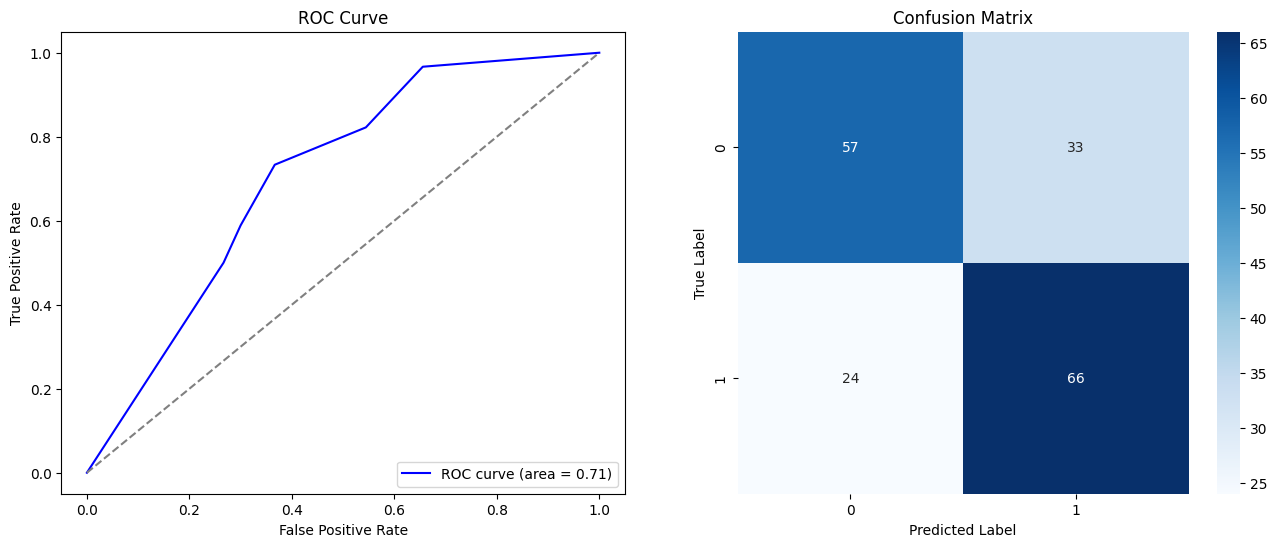

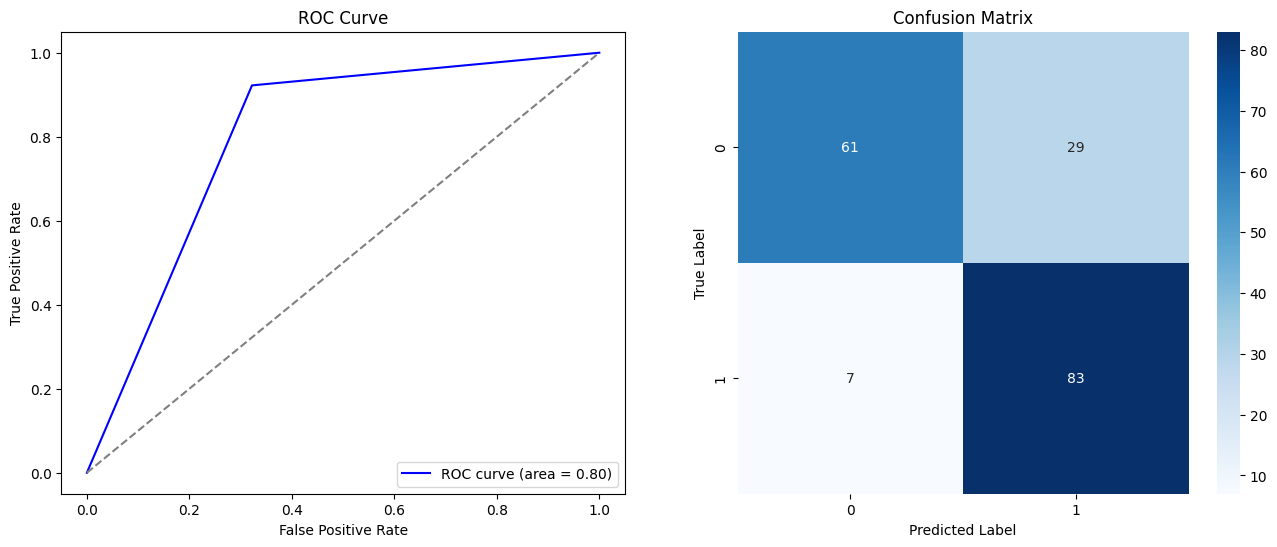

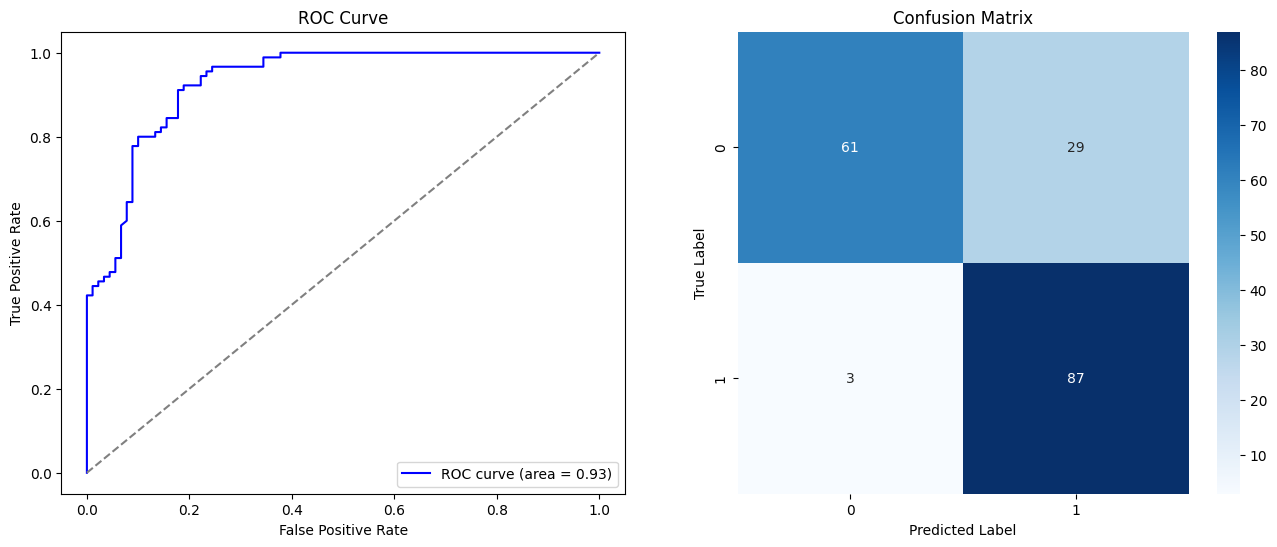

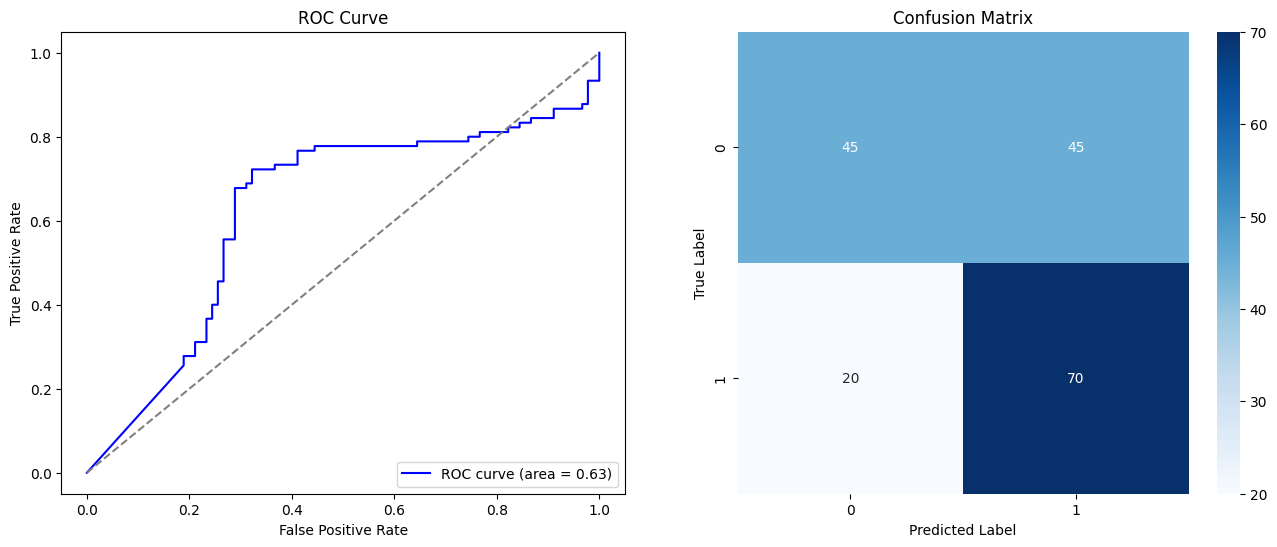

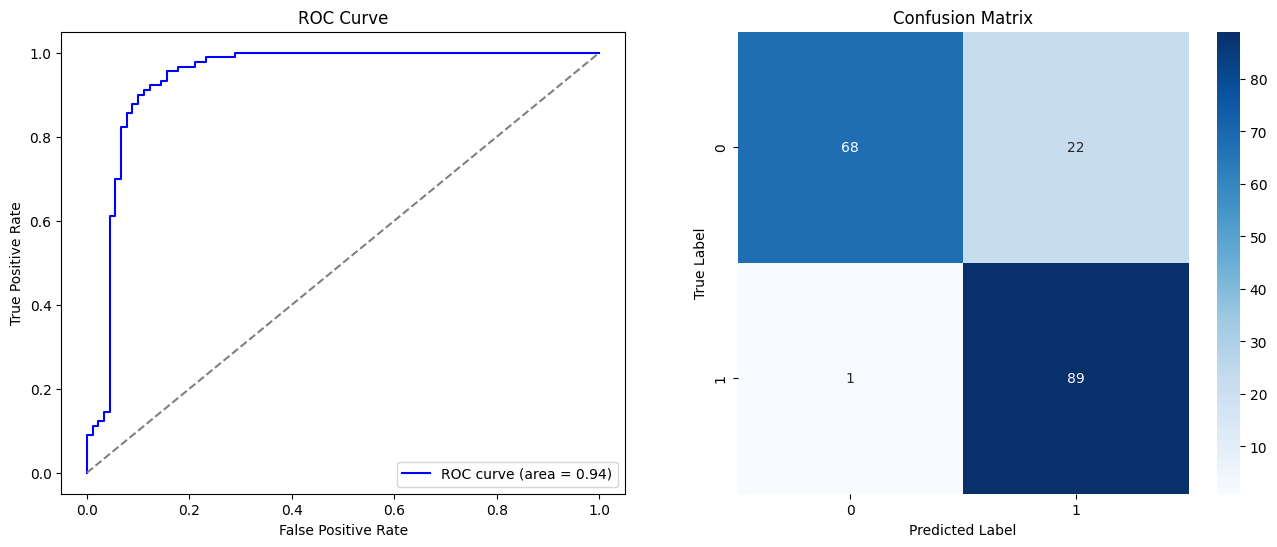

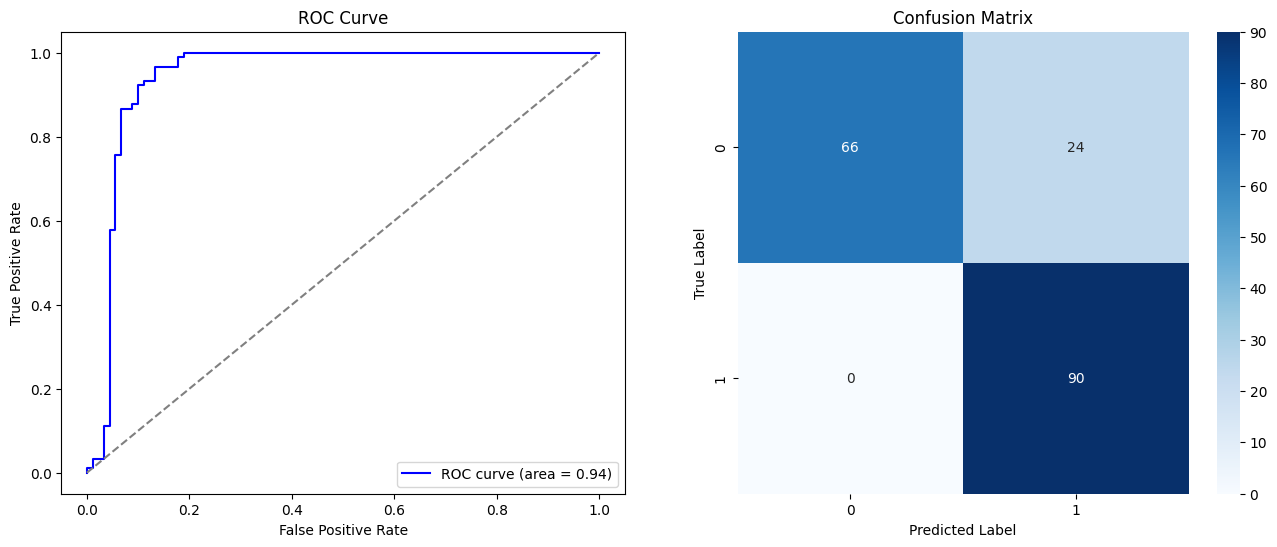

In [23]:


for modelConfig in modelsConfigLst:  # Loop through each model configuration in the list
    results = []
    print(f"Training model for features: {modelConfig['features_type']}")

    # Prepare training and testing data
    hcFeatures = modelConfig["hc_feature"]
    asdFeatures = modelConfig["asd_feature"]
    hcUnseenFeatures = modelConfig["hc_feature_unseen"]
    asdUnseenFeatures = modelConfig["asd_feature_unseen"]

    X_train = np.concatenate((hcFeatures, asdFeatures), axis=0)
    y_train = np.concatenate((np.zeros(hcFeatures.shape[0]), np.ones(asdFeatures.shape[0])), axis=0)

    X_test = np.concatenate((hcUnseenFeatures, asdUnseenFeatures), axis=0)
    y_test = np.concatenate((np.zeros(hcUnseenFeatures.shape[0]), np.ones(asdUnseenFeatures.shape[0])), axis=0)

    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    num_features = X_train.shape[1]  # Get the number of features (second dimension)

    for modelName, (model, paramGrid) in models.items():
        for featureSelectorName, featureSelector in featureSelectors.items():
            print(f"Training {modelName} with {featureSelectorName}...")
            if featureSelector is not None:
                selector = featureSelector
            else:
                selector = None
            skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            bestFold = None
            bestAcc = -np.inf
            bestFoldModel = None
            bestFoldIdx = None
            hyperparamTuningDetails = []

            # Hyperparameter tuning
            if modelConfig["is_hyperparam_tuning"] and paramGrid:
                gridSearch = GridSearchCV(model, paramGrid, cv=10, scoring="accuracy", n_jobs=8, return_train_score=True)
                gridSearch.fit(X_train, y_train)
                model = gridSearch.best_estimator_
                bestParams = gridSearch.best_params_
                print(f"Best hyperparameters for {modelName}: {bestParams}")

                for i, params in enumerate(gridSearch.cv_results_["params"]):
                    meanTestScore = gridSearch.cv_results_["mean_test_score"][i]
                    stdTestScore = gridSearch.cv_results_["std_test_score"][i]
                    hyperparamTuningDetails.append({
                        "params": params,
                        "mean_test_score": meanTestScore,
                        "std_test_score": stdTestScore
                    })
            else:
                bestParams = None

            foldAccuracies = []
            foldPrecisions = []
            foldRecalls = []
            foldF1Scores = []
            selectedFeatures = []
            foldHcTrain = []
            foldMddTrain = []
            foldHcVal = []
            foldMddVal = []
            foldHcTest = []
            foldMddTest = []

            for fold, (trainIdx, valIdx) in enumerate(skf.split(X_train, y_train)):
                XTrain, XVal = X_train[trainIdx], X_train[valIdx]
                yTrain, yVal = y_train[trainIdx], y_train[valIdx]

                hcTrain = int(np.sum(yTrain == 0))
                mddTrain = int(np.sum(yTrain == 1))
                hcVal = int(np.sum(yVal == 0))
                mddVal = int(np.sum(yVal == 1))
                hcTest = int(np.sum(y_test == 0))
                mddTest = int(np.sum(y_test == 1))

                foldHcTrain.append(hcTrain)
                foldMddTrain.append(mddTrain)
                foldHcVal.append(hcVal)
                foldMddVal.append(mddVal)
                foldHcTest.append(hcTest)
                foldMddTest.append(mddTest)

                if selector is not None:
                    XTrain = selector.fit_transform(XTrain, yTrain)
                    XVal = XVal[:, selector.get_support()]

                model.fit(XTrain, yTrain)

                yPred = model.predict(XVal)
                acc = accuracy_score(yVal, yPred)
                prec = precision_score(yVal, yPred)
                rec = recall_score(yVal, yPred)
                f1 = f1_score(yVal, yPred)

                foldAccuracies.append(float(acc))
                foldPrecisions.append(float(prec))
                foldRecalls.append(float(rec))
                foldF1Scores.append(float(f1))

                if selector is not None:
                    selectedFeatures.append(np.where(selector.get_support())[0].tolist())

                modelDir = os.path.join(modelConfig["save_model_dir_path"], f"{modelName}_{featureSelectorName}")
                if not os.path.exists(modelDir):
                    os.makedirs(modelDir)
                modelFilename = os.path.join(modelDir, f"model_fold_{fold + 1}.pkl")
                joblib.dump(model, modelFilename)

                if acc > bestAcc:
                    bestAcc = acc
                    bestFold = model
                    bestFoldIdx = fold

            print(f"Best fold: {bestFoldIdx + 1} with ACC score: {bestAcc:.4f}")

            if selector is not None:
                X_train_selected = selector.fit_transform(X_train, y_train)
                X_test_selected = X_test[:, selector.get_support()]
            else:
                X_train_selected = X_train
                X_test_selected = X_test

            bestFold.fit(X_train_selected, y_train)
            yTestPred = bestFold.predict(X_test_selected)
            finalAccuracy = accuracy_score(y_test, yTestPred)
            finalPrecision = precision_score(y_test, yTestPred)
            finalRecall = recall_score(y_test, yTestPred)
            finalF1 = f1_score(y_test, yTestPred)
            
            whichDirForModelPath = modelConfig["save_model_dir_path"]
            whichFeatureType = modelConfig["features_type"]

            yProb = bestFold.predict_proba(X_test_selected)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, yProb)
            roc_auc = auc(fpr, tpr)
            fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
            ax_roc.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
            ax_roc.plot([0, 1], [0, 1], color='gray', linestyle='--')
            ax_roc.set_xlabel('False Positive Rate')
            ax_roc.set_ylabel('True Positive Rate')
            ax_roc.set_title('ROC Curve')
            ax_roc.legend(loc='lower right')
            roc_plot_filename = os.path.join(whichDirForModelPath, f"{modelName}_{whichFeatureType}_roc.png")
            plt.savefig(roc_plot_filename, dpi=800)
            plt.close(fig_roc)

            cm = confusion_matrix(y_test, yTestPred)
            fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax_cm)  
            ax_cm.set_xlabel('Predicted Label')
            ax_cm.set_ylabel('True Label')
            ax_cm.set_title('Confusion Matrix')
            cm_plot_filename = os.path.join(whichDirForModelPath, f"{modelName}_{whichFeatureType}_cm.png")
            plt.savefig(cm_plot_filename, dpi=800)
            plt.close(fig_cm)
            
            fig, ax = plt.subplots(1, 2, figsize=(16, 6))
            ax[0].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
            ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
            ax[0].set_xlabel('False Positive Rate')
            ax[0].set_ylabel('True Positive Rate')
            ax[0].set_title('ROC Curve')
            ax[0].legend(loc='lower right')
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax[1])  # Added cbar=True for color bar
            ax[1].set_xlabel('Predicted Label')
            ax[1].set_ylabel('True Label')
            ax[1].set_title('Confusion Matrix')
            combined_plot_filename = os.path.join(whichDirForModelPath, f"{modelName}_{whichFeatureType}_roc_cm_combined.png")
            plt.savefig(combined_plot_filename, dpi=800)

            results.append({
                "model": modelName,
                "feature_selection": featureSelectorName,
                "features_type": modelConfig["features_type"],
                "num_features": num_features,
                "avg_accuracy": f"{np.mean(foldAccuracies):.4f} ± {np.std(foldAccuracies):.4f}",
                "avg_precision": f"{np.mean(foldPrecisions):.4f} ± {np.std(foldPrecisions):.4f}",
                "avg_recall": f"{np.mean(foldRecalls):.4f} ± {np.std(foldRecalls):.4f}",
                "avg_f1_score": f"{np.mean(foldF1Scores):.4f} ± {np.std(foldF1Scores):.4f}",
                "final_accuracy": f"{finalAccuracy:.4f}",
                "final_precision": f"{finalPrecision:.4f}",
                "final_recall": f"{finalRecall:.4f}",
                "final_f1_score": f"{finalF1:.4f}",
                "significant_features": np.unique([item for sublist in selectedFeatures for item in sublist]).tolist(),
                "folds_accuracy": foldAccuracies,
                "folds_precision": foldPrecisions,
                "folds_recall": foldRecalls,
                "folds_f1_score": foldF1Scores,
                "fold_hc_train": [int(x) for x in foldHcTrain], 
                "fold_mdd_train": [int(x) for x in foldMddTrain],  
                "fold_hc_val": [int(x) for x in foldHcVal], 
                "fold_mdd_val": [int(x) for x in foldMddVal],  
                "fold_hc_test": [int(x) for x in foldHcTest],  
                "fold_mdd_test": [int(x) for x in foldMddTest],
                "best_fold": bestFoldIdx + 1,
                "best_hyperparameters": bestParams,
                "hyperparam_tuning_details": hyperparamTuningDetails
            })

    # Save results for this model configuration
    saveDir = modelConfig["save_model_dir_path"]
    resultsDf = pd.DataFrame(results)
    csvFilename = os.path.join(saveDir, f"results_{num_features}_features.csv")
    excelFilename = os.path.join(saveDir, f"results_{num_features}_features.xlsx")
    resultsDf.to_csv(csvFilename, index=False)
    resultsDf.to_excel(excelFilename, index=False)
    print(f"Results saved to {csvFilename} and {excelFilename}")

# Print results
for result in results:
    print(f"\n{result['model']} with {result['feature_selection']} - Final evaluation")
    print(f"Final Accuracy: {result['final_accuracy']}")
    print(f"Final Precision: {result['final_precision']}")
    print(f"Final Recall: {result['final_recall']}")
    print(f"Final F1 Score: {result['final_f1_score']}")
    if result["best_hyperparameters"]:
        print(f"Best Hyperparameters: {result['best_hyperparameters']}")